In [1]:
import sys
sys.path.append('..')

from models.backbone_R2U_Net import build_backbone
from models.TopDiG import build_TopDiG
from dataloader_cocostyle import image_graph_collate_road_network_coco, min_max_normalize, CrowdAI

from PIL import Image
from skimage.transform import resize
import matplotlib.pyplot as plt
import yaml
import json
import torch
import numpy as np

class obj:
    def __init__(self, dict1):
        self.__dict__.update(dict1)
        
def dict2obj(dict1):
    return json.loads(json.dumps(dict1), object_hook=obj)

loading annotations into memory...
Done (t=0.16s)
creating index...
index created!
Built Dataset Options:
--Num.of images: 1355
--Gap Distance: 10 --Sigma: 1.0 --nms: False
torch.Size([6, 3, 320, 320])


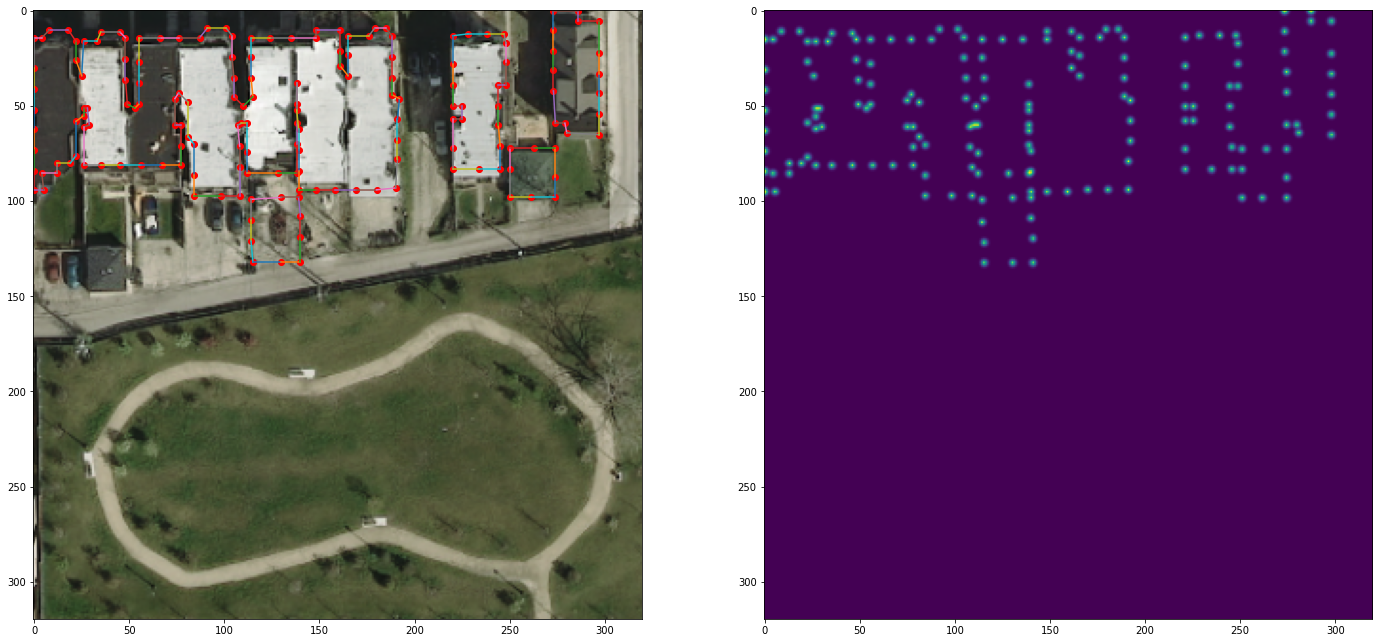

In [3]:
dataset = CrowdAI(images_directory='/nas/k8s/dev/research/doyoungi/dataset/Inria_building/cocostyle_inria_test/images',
                    annotations_path='/nas/k8s/dev/research/doyoungi/dataset/Inria_building/cocostyle_inria_test/annotation.json',)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=6, collate_fn=image_graph_collate_road_network_coco, shuffle=False)

print(next(iter(dataloader))[0].shape) # image

data = next(iter(dataloader))

# 6개의 이미지 중 1번째 GT
image = data[0][1].detach().cpu().numpy().transpose(1,2,0)
heatmap =  data[1][1].detach().cpu().numpy()
nodes = data[2][1].detach().cpu().numpy() * image.shape[0]
edges = data[3][1].detach().cpu().numpy()

gt_nodes = nodes.astype('int64')

# Visualize
fig, ax = plt.subplots(1, 2, figsize=(24, 12))
ax[0].imshow(min_max_normalize(image, 0))
ax[0].scatter(gt_nodes[:,1], gt_nodes[:,0], color='r')

for e in edges:
    connect = np.stack([gt_nodes[e[0]], gt_nodes[e[1]]], axis=0)
    ax[0].plot(connect[:,1], connect[:,0])

ax[1].imshow(heatmap[0])
plt.show()

In [4]:
device = 'cuda'
images = torch.zeros((6,3,320,320)).to(device)
for i, image in enumerate(data[0]):
    image = resize(image, (3, 320, 320), anti_aliasing=True, preserve_range=True)
    images[i] = torch.tensor(image).to(device)

tensor([-15.1713, -15.0727, -14.9713,  ...,   4.8213,   4.9047,   4.9264],
       device='cuda:0')


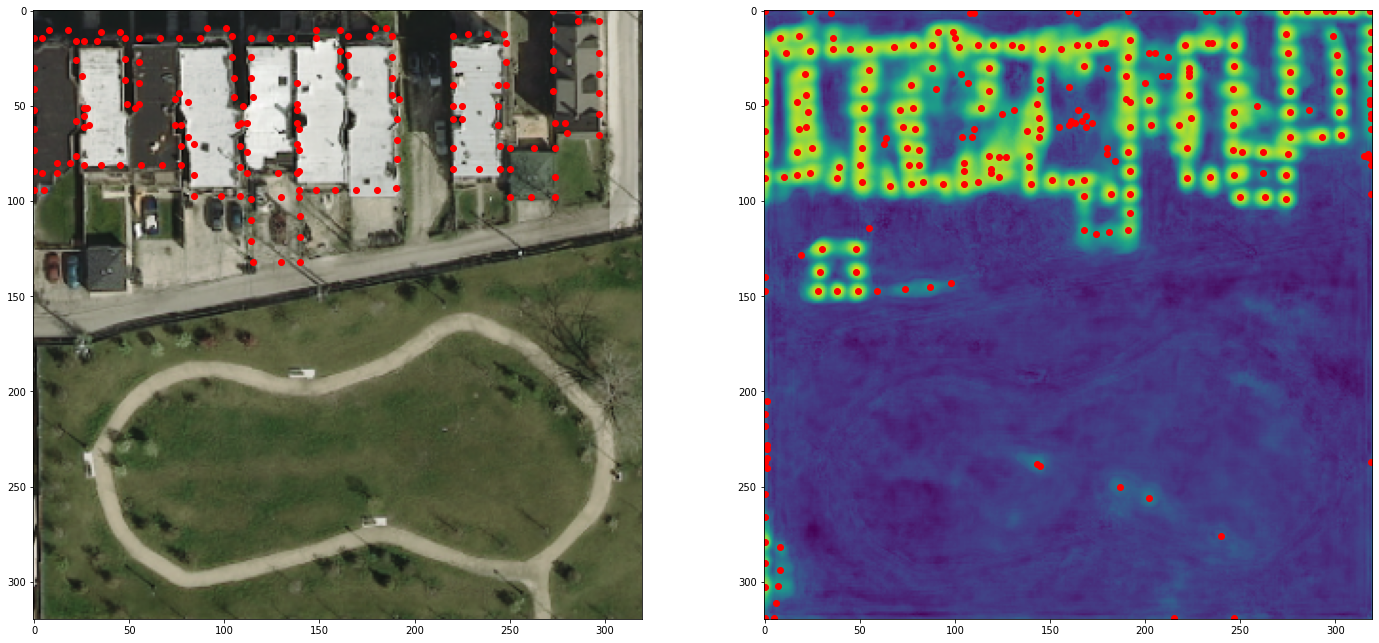

In [5]:
config = "../configs/topdig/topdig_10_1.0_control_diag.yaml"
config2 = '../configs/pretrain/pretrain_10_0.7.yaml'
# ckpt_backbone_path = 'work_dirs/R2U_Net_pretrain/runs/baseline_R2U_Net_pretrain_epoch60_5e-6_10_0.7_10/models/epochs_50.pth'
# ckpt_backbone_path = "/nas/k8s/dev/research/intern/tsgil/relationformer/work_dirs/R2U_Net_pretrain/runs/baseline_R2U_Net_pretrain_epoch200_5e-6_10/models/epochs_100.pth"
# ckpt_backbone_path = "work_dirs/R2U_Net_pretrain/runs/baseline_R2U_Net_pretrain_epoch200_5e-6_10_0.7_control_10/models/epochs_100.pth"
# ckpt_backbone_path = "work_dirs/R2U_Net_pretrain/runs/baseline_R2U_Net_pretrain_epoch200_5e-6_10_1.0_control_10/models/epochs_100.pth"
ckpt_backbone_path = "../work_dirs/R2U_Net_pretrain/runs/baseline_R2U_Net_pretrain_epoch200_5e-6_10_1.0_batch8_cocoinria_nms_10/models/epochs_100.pth"

R2U = build_backbone(config2).to(device)
ckpt = torch.load(ckpt_backbone_path, map_location='cpu')
R2U.load_state_dict(ckpt['model_state_dict'])
# R2U.eval()
R2U.train()
with torch.no_grad():
    ftm_R2U, htm_R2U, nms_R2U = R2U(images)
print(htm_R2U[1].unique())
image = images[1].detach().cpu().numpy().transpose(1,2,0)
nodes = nms_R2U[1][1].detach().cpu().numpy()
htm = htm_R2U[1].detach().cpu().numpy()[0]


# Visualize
fig, ax = plt.subplots(1,2, figsize=(24, 12))
ax[0].imshow(min_max_normalize(image, 0))
ax[1].scatter(nodes[:,1], nodes[:,0], color='r')
ax[1].imshow(htm)
ax[0].scatter(gt_nodes[:,1], gt_nodes[:,0], color='r')
plt.show()

print(nodes.shape, gt_nodes.shape)
print(type(nodes), type(gt_nodes))
nodes = torch.tensor(nodes).float()
gt_nodes = torch.tensor(gt_nodes).float()

In [6]:
from models.DGS import Matcher
with open(config) as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
config = dict2obj(config)

In [7]:
nearest_matcher = Matcher(config=config, matcher='Nearest')
hungarian_matcher = Matcher(config=config, matcher='Hungarian')
sinkhorn_matcher = Matcher(config=config, matcher='Sinkhorn')

width = 320

outputs, targets = {}, {}
targets['nodes'] = torch.tensor(gt_nodes).unsqueeze(0).float() / width
targets['edges'] = torch.tensor(edges).unsqueeze(0)
outputs['pred_nodes'] = torch.tensor(nodes).unsqueeze(0).float() / width
outputs['pred_heatmaps'] = torch.tensor(htm).unsqueeze(0).unsqueeze(0)
nearest_adj_matrix, _, nearest_matched_pairs = nearest_matcher(outputs, targets)
hungarian_adj_matrix, _, hungarian_matched_pairs = hungarian_matcher(outputs, targets)
# _, _, sinkhorn_matched_pairs = sinkhorn_matcher(outputs, targets, config=config)

In [8]:
htms = np.stack([htm, htm, htm], axis=2)
draw_image = np.concatenate([min_max_normalize(image, 0), min_max_normalize(htms,2)], axis=1)

draw_gt_node = gt_nodes # .detach().cpu().numpy()
draw_pred_node = nodes + [0, 320]

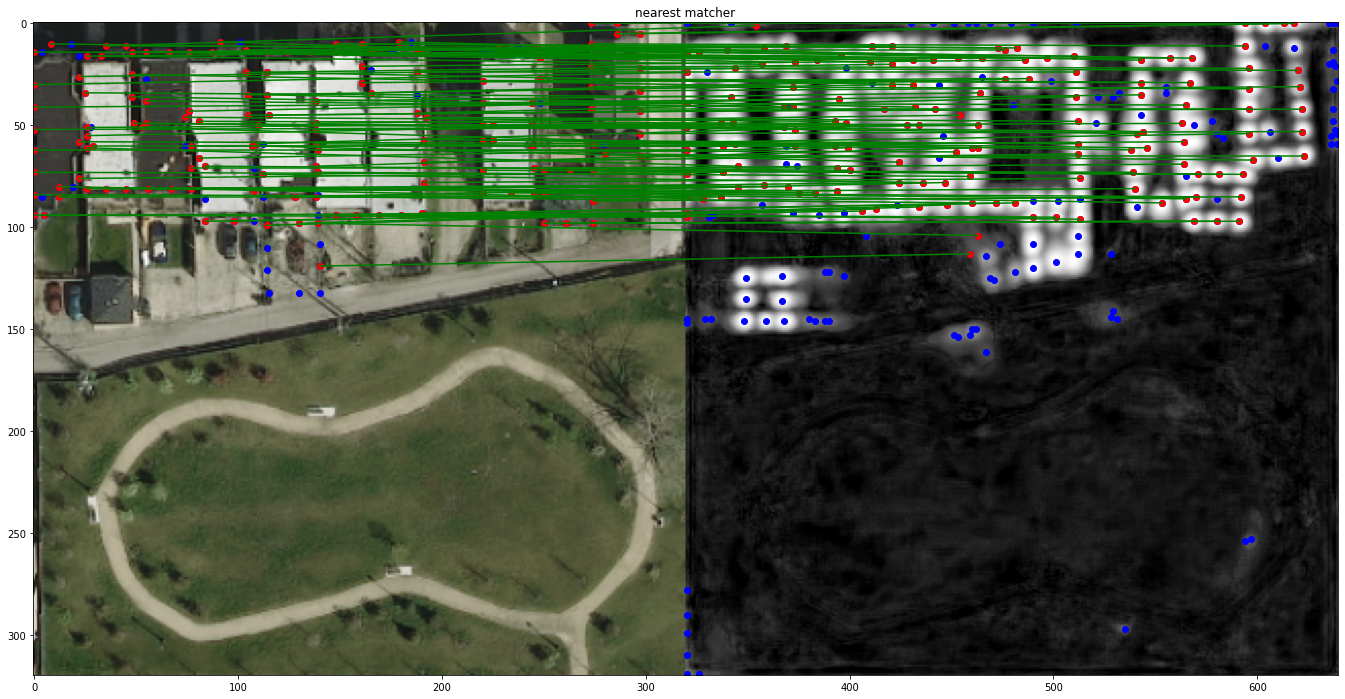

In [17]:
matched_pairs = nearest_matched_pairs[0]
# Visualize
fig, ax = plt.subplots(1,1, figsize=(24, 12))
ax.imshow(draw_image)

ax.scatter(draw_gt_node[:,1], draw_gt_node[:,0], color='b')
ax.scatter(draw_pred_node[:,1], draw_pred_node[:,0], color='b')

ax.scatter(draw_gt_node[matched_pairs[1]][:,1], draw_gt_node[matched_pairs[1]][:,0], color='r')
ax.scatter(draw_pred_node[matched_pairs[0]][:,1], draw_pred_node[matched_pairs[0]][:,0], color='r')

match_indices = np.array(matched_pairs).transpose(1,0)
for i in match_indices:
    p1 = np.array(draw_gt_node[i[1]])
    p2 = np.array(draw_pred_node[i[0]])
    p = np.stack([p1, p2], axis=0)
    ax.plot(p[:,1], p[:,0], 'g')
plt.title("nearest matcher")
plt.show()

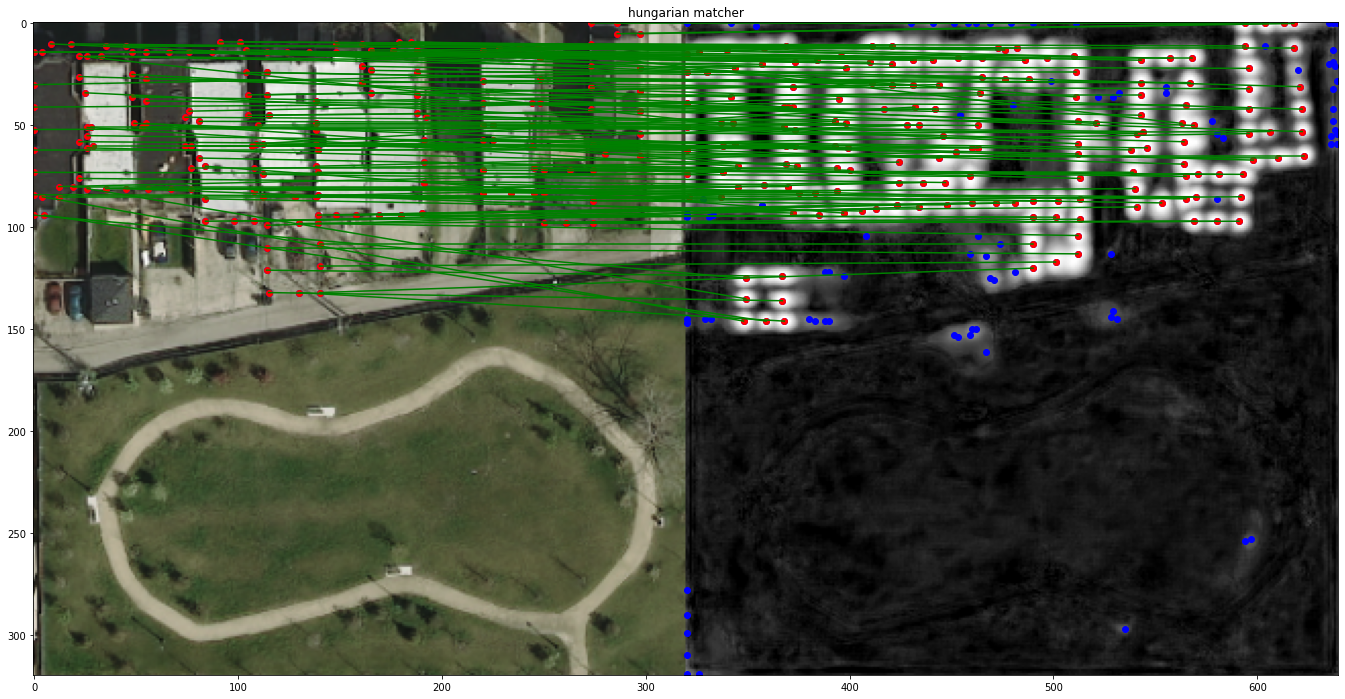

In [10]:
match_indices = hungarian_matched_pairs[0]

# Visualize
fig, ax = plt.subplots(1,1, figsize=(24, 12))
ax.imshow(draw_image)

ax.scatter(draw_gt_node[:,1], draw_gt_node[:,0], color='b')
ax.scatter(draw_pred_node[:,1], draw_pred_node[:,0], color='b')

ax.scatter(draw_gt_node[match_indices[1]][:,1], draw_gt_node[match_indices[1]][:,0], color='r')
ax.scatter(draw_pred_node[match_indices[0]][:,1], draw_pred_node[match_indices[0]][:,0], color='r')

match_indices = np.array(match_indices).transpose(1,0)
for i in match_indices:
    p1 = np.array(draw_gt_node[i[1]])
    p2 = np.array(draw_pred_node[i[0]])
    p = np.stack([p1, p2], axis=0)
    ax.plot(p[:,1], p[:,0], 'g')
plt.title("hungarian matcher")
plt.show()

In [11]:
def edge_list_to_adj_matrix(edge_list):
    # Flatten the edge list and find unique vertices
    vertices = np.unique(edge_list.flatten())
    
    # Create a mapping from vertex value to index
    vertex_to_index = {vertex: i for i, vertex in enumerate(vertices)}
    
    # Initialize an adjacency matrix of size based on the number of unique vertices
    num_vertices = len(vertices)
    adj_matrix = np.zeros((num_vertices, num_vertices), dtype=int)
    
    # Populate the adjacency matrix
    for edge in edge_list:
        src, dest = edge
        adj_matrix[vertex_to_index[src], vertex_to_index[dest]] = 1

    return adj_matrix


def remove_vertices_and_redirect_edges(adj_matrix, vertices_to_remove):
    n = adj_matrix.shape[0]
    sorted_vertices_to_remove = sorted(vertices_to_remove, reverse=True)

    adj_matrix = adj_matrix.copy()
    for vertex_to_remove in sorted_vertices_to_remove:
        if vertex_to_remove < 0 or vertex_to_remove >= n:
            raise ValueError("Vertex index out of bounds")

        incoming = np.where(adj_matrix[:, vertex_to_remove] == 1)[0]
        outgoing = np.where(adj_matrix[vertex_to_remove, :] == 1)[0]

        if len(incoming) > 0 and len(outgoing) > 0:
            for i in incoming:
                for j in outgoing:
                    adj_matrix[i, j] = 1

        adj_matrix[vertex_to_remove, :] = 0  # Set entire row to 0
        adj_matrix[:, vertex_to_remove] = 0  # Set entire column to 0

        adj_matrix[vertex_to_remove, vertex_to_remove] = 1  # Set entire row to 0

    return adj_matrix

In [19]:
# match_indices = hungarian_matched_pairs[0]
# match_indices = sinkhorn_matched_pairs[0]
# matched_pairs = match_nodes(gt_nodes, nodes, min_dist=12)
# matched_pairs = match_nodes(torch.tensor(gt_nodes).float(), torch.tensor(nodes).float(), min_dist=10)
match_indices = nearest_matched_pairs[0]

# indices = [matched_pairs]
indices = [match_indices]
b = 0
k = 256
n = 170 # number of targets
mapping = {j:i for i,j in zip(indices[b][0].tolist(),indices[b][1].tolist())}
key_list = list(mapping.keys())
non_matched_key = [i for i in range(n) if not i in key_list]

adj_ori = edge_list_to_adj_matrix(edges)
adj_modi = remove_vertices_and_redirect_edges(adj_ori, non_matched_key)
ori_edges = np.array(np.where(adj_ori == 1)).transpose(1,0) # gt_sequence
mod_edges = np.array(np.where(adj_modi == 1)).transpose(1,0) # gt_sequence

print(non_matched_key) # this is gt outputs..

[1, 19, 20, 26, 50, 59, 70, 95, 96, 99, 100, 112, 120, 124, 126, 130, 142, 143, 144, 145, 147, 148, 149, 151, 152, 153, 157, 160, 161, 167]


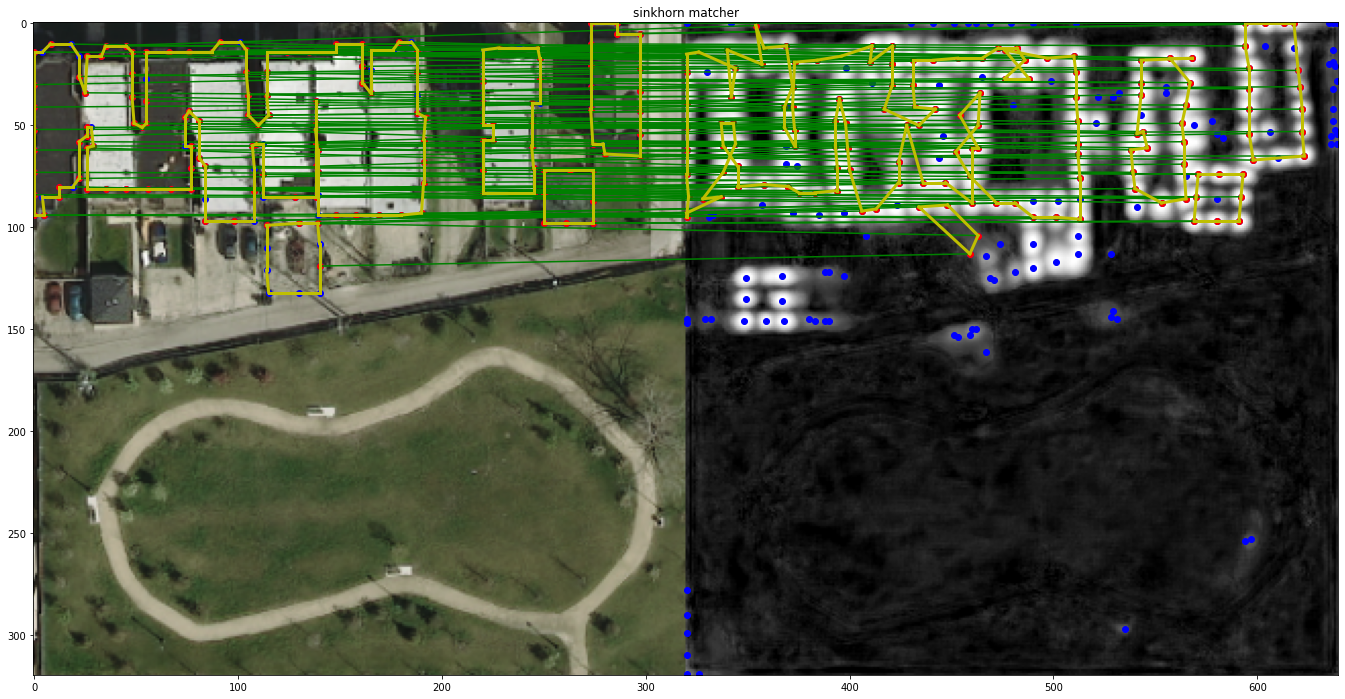

In [20]:

# Visualize
fig, ax = plt.subplots(1,1, figsize=(24, 12))
ax.imshow(draw_image)

ax.scatter(draw_gt_node[:,1], draw_gt_node[:,0], color='b')
ax.scatter(draw_pred_node[:,1], draw_pred_node[:,0], color='b')

ax.scatter(draw_gt_node[match_indices[1]][:,1], draw_gt_node[match_indices[1]][:,0], color='r')
ax.scatter(draw_pred_node[match_indices[0]][:,1], draw_pred_node[match_indices[0]][:,0], color='r')

match_indices = np.array(match_indices).transpose(1,0)
match_dict = {i[1]:i[0] for i in match_indices.tolist()}

for i in match_indices:
    p1 = np.array(draw_gt_node[i[1]])
    p2 = np.array(draw_pred_node[i[0]])
    p = np.stack([p1, p2], axis=0)
    ax.plot(p[:,1], p[:,0], 'g')

for e in edges:
    p1 = np.array(draw_gt_node[e[1]])
    p2 = np.array(draw_gt_node[e[0]])
    p = np.stack([p1, p2], axis=0)
    ax.plot(p[:,1], p[:,0], 'y', linewidth=3)

for e in mod_edges:
    if not set(e) & set(non_matched_key):
        p1 = np.array(draw_pred_node[match_dict[e[1]]])
        p2 = np.array(draw_pred_node[match_dict[e[0]]])
        p = np.stack([p1, p2], axis=0)
        ax.plot(p[:,1], p[:,0], 'y', linewidth=3)

# for e in ori_edges:
#     if not set(e) & set(non_matched_key):
#         p1 = np.array(draw_pred_node[match_dict[e[1]]])
#         p2 = np.array(draw_pred_node[match_dict[e[0]]])
#         p = np.stack([p1, p2], axis=0)
#         ax.plot(p[:,1], p[:,0], 'r', linewidth=3)

plt.title("sinkhorn matcher")
plt.show()

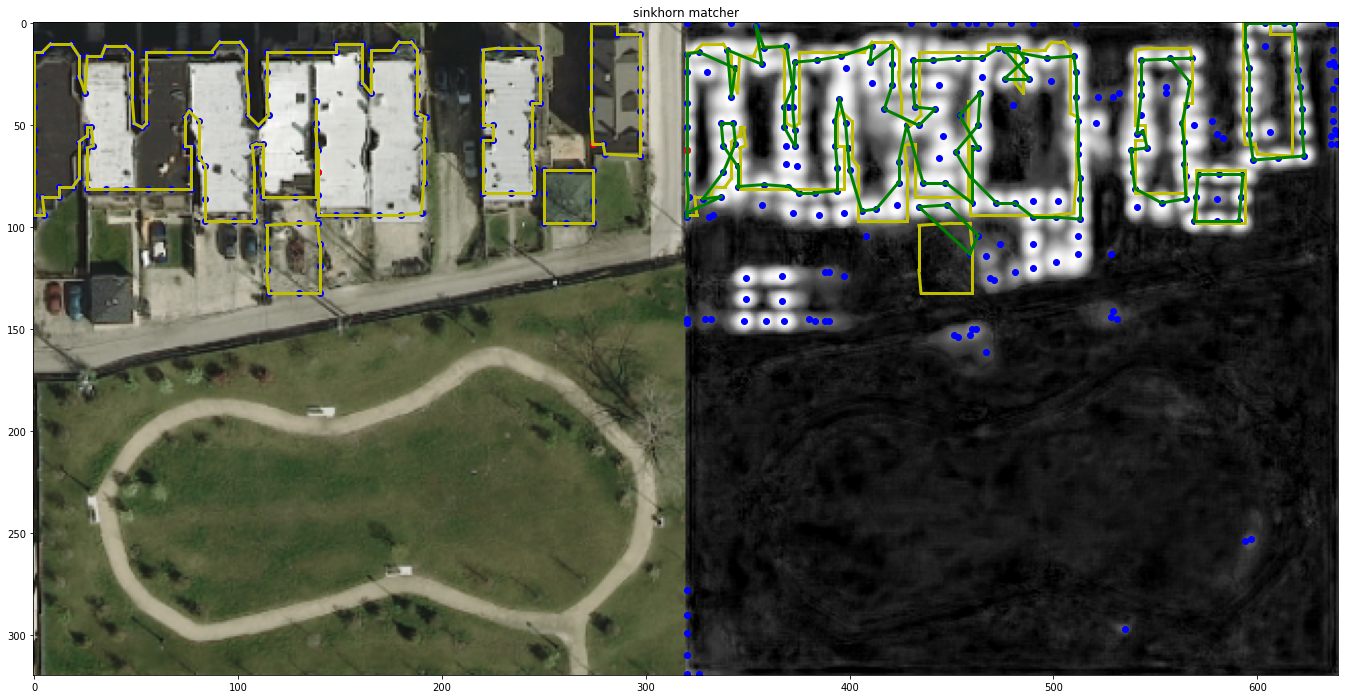

In [29]:
# Visualize
fig, ax = plt.subplots(1,1, figsize=(24, 12))
ax.imshow(draw_image)

ax.scatter(draw_gt_node[:,1], draw_gt_node[:,0], color='b')
ax.scatter(draw_pred_node[:,1], draw_pred_node[:,0], color='b')

ax.scatter(draw_gt_node[match_indices[1]][:,1], draw_gt_node[match_indices[1]][:,0], color='r')
ax.scatter(draw_pred_node[match_indices[0]][:,1], draw_pred_node[match_indices[0]][:,0], color='r')

match_indices = np.array(match_indices).transpose(1,0)
match_dict = {i[1]:i[0] for i in match_indices.tolist()}

for e in edges:
    p1 = np.array(draw_gt_node[e[1]])
    p2 = np.array(draw_gt_node[e[0]])
    p = np.stack([p1, p2], axis=0)
    ax.plot(p[:,1], p[:,0], 'y', linewidth=3)

# for e in mod_edges:
#     if not set(e) & set(non_matched_key):
#         p1 = np.array(draw_pred_node[match_dict[e[1]]])
#         p2 = np.array(draw_pred_node[match_dict[e[0]]])
#         p = np.stack([p1, p2], axis=0)
#         ax.plot(p[:,1], p[:,0], 'y', linewidth=3)

for e in edges:
    p1 = np.array(draw_gt_node[e[1]])
    p2 = np.array(draw_gt_node[e[0]])
    p = np.stack([p1, p2], axis=0)
    ax.plot(p[:,1]+320, p[:,0], 'y', linewidth=3)


loc = np.array(np.where(nearest_adj_matrix[0].detach().cpu().numpy() == 1)).transpose(1,0)
for e in loc:
    p1 = np.array(draw_pred_node[e[1]])
    p2 = np.array(draw_pred_node[e[0]])
    p = np.stack([p1, p2], axis=0)
    ax.plot(p[:,1], p[:,0], 'g', linewidth=3)

# loc = np.array(np.where(hungarian_adj_matrix[0].detach().cpu().numpy() == 1)).transpose(1,0)
# for e in loc:
#     p1 = np.array(draw_pred_node[e[1]])
#     p2 = np.array(draw_pred_node[e[0]])
#     p = np.stack([p1, p2], axis=0)
#     ax.plot(p[:,1], p[:,0], 'r', linewidth=3)

plt.title("sinkhorn matcher")
plt.show()